In [1]:
#import library
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

In [2]:
#class algoritma klasifikasi Fuzzy K-Nearest Neighbor
class FuzzyKNN(BaseEstimator, ClassifierMixin):
    #function inisialisasi
    def __init__(self, k, plot=False):
        self.k = k
        self.plot = plot
        
    #mengecek parameter yang dimasukkan apakah sudah sesuai sebelum menggunakan algoritma FKNN
    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
            
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')
        
    #melatih/membuat model berdasarkan data train yang dimasukkan
    def fit(self, X, y=None):
        self._check_params(X,y) #memanggil fungsi check_parameter
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        
        classes = list(set(y))
        classes.sort()
        self.classes = classes
        
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        
        self.memberships = self._compute_memberships() #memanggil fungsi compute membership
        
        self.df['membership'] = self.memberships
        
        self.fitted_ = True
        return self
    
    #memprediksi data baru (testing) masuk ke dalam class mana
    def predict(self, X, m):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            y_pred = []
            
            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
                
                votes = {}
                for c in self.classes:
                    den = 0
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        den += 1 / (dist ** (2 / (m-1)))
                    
                    neighbors_votes = []
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        num = (neighbors.iloc[n].membership[c]) / (dist ** (2 / (m-1)))
                        
                        vote = num/den
                        neighbors_votes.append(vote)
                    votes[c] = np.sum(neighbors_votes)
                    
                pred = max(votes.items(), key=operator.itemgetter(1))[0]
                y_pred.append((pred, votes))
                
            return y_pred
        
    #menampilkan nilai akurasi dari model yang sudah dibuat
    def score(self, X, y, m):
        if self.fitted_ == None:
            raise Exception('score() called before fit()')
        else:
            predictions = self.predict(X, m)
            y_pred = [t[0] for t in predictions]
            confidences = [t[1] for t in predictions]
            
            return accuracy_score(y_pred=y_pred, y_true=y)
    
    #mencari tetangga terdekat berdasarkan K
    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values
        
        df['distances'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]
        
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

    #menentukan hasil tetangga terdekat dari proses function find KNN        
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        
        return counts
        
    #menghitung inisialisasi fuzzy untuk menghitung nilai keanggotaannya
    def _compute_memberships(self):
        memberships = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y[i]
            
            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x) #memanggil fungsi find_knn
            counts = self._get_counts(neighbors)
        
            membership = dict()
            for c in self.classes:
                try:
                    #rumus inisialisasi fuzzy
                    uci = 0.49 * (counts[c] / self.k)
                    if c == y:
                        uci += 0.51
                    membership[c] = uci
                except:
                    membership[c] = 0
                    
            memberships.append(membership)
        return memberships

In [3]:
ukuran_test1 = 0.2
ukuran_test2 = 0.2
ukuran_test3 = 0.8

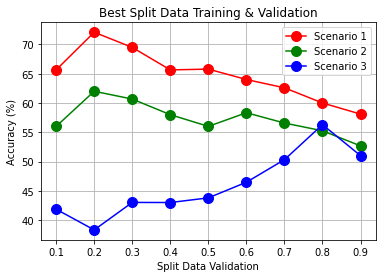

In [4]:
iterasi_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy1 = []
accuracy2 = []
accuracy3 = []

data_train1 = pd.read_csv('csv/data_train1617.csv')
data_train2 = pd.read_csv('csv/data_train_undersample.csv')
data_train3 = pd.read_csv('csv/data_train_oversample.csv')

mk1 = data_train1
mk1 = mk1.drop(["KK"], axis=1)
mk1 = mk1.to_numpy()
mk2 = data_train2
mk2 = mk2.drop(["KK"], axis=1)
mk2 = mk2.to_numpy()
mk3 = data_train3
mk3 = mk3.drop(["KK"], axis=1)
mk3 = mk3.to_numpy()

kk1 = data_train1["KK"]
kk1 = kk1.astype(int)
kk1 = kk1.to_numpy()
kk2 = data_train2["KK"]
kk2 = kk2.astype(int)
kk2 = kk2.to_numpy()
kk3 = data_train3["KK"]
kk3 = kk3.astype(int)
kk3 = kk3.to_numpy()

X1 = mk1
y1 = kk1
X2 = mk2
y2 = kk2
X3 = mk3
y3 = kk3

for i in iterasi_test:
    xTrain1, xTest1, yTrain1, yTest1 = train_test_split(X1,y1, test_size=i, random_state = 42) #menggunakan test size terbaik dari evaluasi sebelumnya
    xTrain2, xTest2, yTrain2, yTest2 = train_test_split(X2,y2, test_size=i, random_state = 42) #menggunakan test size terbaik dari evaluasi sebelumnya
    xTrain3, xTest3, yTrain3, yTest3 = train_test_split(X3,y3, test_size=i, random_state = 42) #menggunakan test size terbaik dari evaluasi sebelumnya    
    
    FuzzyKNN_Model1 = FuzzyKNN(5)
    FuzzyKNN_Model1.fit(xTrain1, yTrain1)
    hasil = 100 * FuzzyKNN_Model1.score(xTest1, yTest1, 4)
    accuracy1.append(hasil)

    FuzzyKNN_Model2 = FuzzyKNN(5)
    FuzzyKNN_Model2.fit(xTrain2, yTrain2)
    hasil = 100 * FuzzyKNN_Model2.score(xTest2, yTest2, 4)
    accuracy2.append(hasil)
    
    FuzzyKNN_Model3 = FuzzyKNN(5)
    FuzzyKNN_Model3.fit(xTrain3, yTrain3)
    hasil = 100 * FuzzyKNN_Model3.score(xTest3, yTest3, 4)
    accuracy3.append(hasil)
    
i = accuracy1[0]
idx = 0
index = 0
for value in accuracy1:
    if i < value:
        i = value
        index = idx
    idx = idx + 1
random_state_terbaik1 = iterasi_test[index]

i = accuracy2[0]
idx = 0
index = 0
for value in accuracy2:
    if i < value:
        i = value
        index = idx
    idx = idx + 1
random_state_terbaik2 = iterasi_test[index]

i = accuracy3[0]
idx = 0
index = 0
for value in accuracy3:
    if i < value:
        i = value
        index = idx
    idx = idx + 1
random_state_terbaik3 = iterasi_test[index]

    
plt.plot(iterasi_test, accuracy1, label = 'Scenario 1', color = 'red', marker='o', markerfacecolor='red', markersize=10)
plt.plot(iterasi_test, accuracy2, label = 'Scenario 2', color = 'green', marker='o', markerfacecolor='green', markersize=10)
plt.plot(iterasi_test, accuracy3, label = 'Scenario 3', color = 'blue', marker='o', markerfacecolor='blue', markersize=10)


plt.title('Best Split Data Training & Validation')
plt.xlabel('Split Data Validation')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.grid()

plt.show()

In [5]:
accuracy1

[65.65656565656566,
 72.08121827411168,
 69.49152542372882,
 65.64885496183206,
 65.78411405295316,
 64.00679117147709,
 62.59097525473072,
 60.0,
 58.0973952434881]

In [6]:
accuracy2

[56.00000000000001,
 62.0,
 60.66666666666667,
 57.99999999999999,
 56.00000000000001,
 58.333333333333336,
 56.57142857142857,
 55.25,
 52.666666666666664]

In [7]:
accuracy3

[41.84782608695652,
 38.315217391304344,
 43.01270417422868,
 42.993197278911566,
 43.790849673202615,
 46.46098003629764,
 50.311041990668734,
 56.29680054458815,
 50.99818511796733]

In [8]:
ukuran_test1 = random_state_terbaik1
ukuran_test2 = random_state_terbaik2
ukuran_test3 = random_state_terbaik3

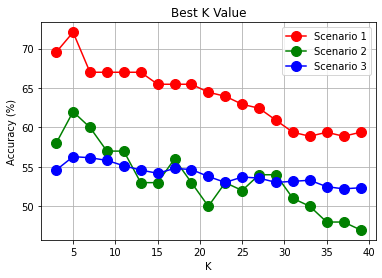

In [9]:
iterasi_test = [3, 5, 7 , 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]

accuracy1 = []
accuracy2 = []
accuracy3 = []

data_train1 = pd.read_csv('csv/data_train1617.csv')
data_train2 = pd.read_csv('csv/data_train_undersample.csv')
data_train3 = pd.read_csv('csv/data_train_oversample.csv')

mk1 = data_train1
mk1 = mk1.drop(["KK"], axis=1)
mk1 = mk1.to_numpy()
mk2 = data_train2
mk2 = mk2.drop(["KK"], axis=1)
mk2 = mk2.to_numpy()
mk3 = data_train3
mk3 = mk3.drop(["KK"], axis=1)
mk3 = mk3.to_numpy()

kk1 = data_train1["KK"]
kk1 = kk1.astype(int)
kk1 = kk1.to_numpy()
kk2 = data_train2["KK"]
kk2 = kk2.astype(int)
kk2 = kk2.to_numpy()
kk3 = data_train3["KK"]
kk3 = kk3.astype(int)
kk3 = kk3.to_numpy()

X1 = mk1
y1 = kk1
X2 = mk2
y2 = kk2
X3 = mk3
y3 = kk3

for i in iterasi_test:
    xTrain1, xTest1, yTrain1, yTest1 = train_test_split(X1,y1, test_size=ukuran_test1, random_state = 42) #menggunakan test size terbaik dari evaluasi sebelumnya
    xTrain2, xTest2, yTrain2, yTest2 = train_test_split(X2,y2, test_size=ukuran_test2, random_state = 42) #menggunakan test size terbaik dari evaluasi sebelumnya
    xTrain3, xTest3, yTrain3, yTest3 = train_test_split(X3,y3, test_size=ukuran_test3, random_state = 42) #menggunakan test size terbaik dari evaluasi sebelumnya    
    
    FuzzyKNN_Model1 = FuzzyKNN(i)
    FuzzyKNN_Model1.fit(xTrain1, yTrain1)
    hasil = 100 * FuzzyKNN_Model1.score(xTest1, yTest1, 4)
    accuracy1.append(hasil)

    FuzzyKNN_Model2 = FuzzyKNN(i)
    FuzzyKNN_Model2.fit(xTrain2, yTrain2)
    hasil = 100 * FuzzyKNN_Model2.score(xTest2, yTest2, 4)
    accuracy2.append(hasil)
    
    FuzzyKNN_Model3 = FuzzyKNN(i)
    FuzzyKNN_Model3.fit(xTrain3, yTrain3)
    hasil = 100 * FuzzyKNN_Model3.score(xTest3, yTest3, 4)
    accuracy3.append(hasil)
    
i = accuracy1[0]
idx = 0
index = 0
for value in accuracy1:
    if i < value:
        i = value
        index = idx
    idx = idx + 1
random_state_terbaik1 = iterasi_test[index]

i = accuracy2[0]
idx = 0
index = 0
for value in accuracy2:
    if i < value:
        i = value
        index = idx
    idx = idx + 1
random_state_terbaik2 = iterasi_test[index]

i = accuracy3[0]
idx = 0
index = 0
for value in accuracy3:
    if i < value:
        i = value
        index = idx
    idx = idx + 1
random_state_terbaik3 = iterasi_test[index]

    
plt.plot(iterasi_test, accuracy1, label = 'Scenario 1', color = 'red', marker='o', markerfacecolor='red', markersize=10)
plt.plot(iterasi_test, accuracy2, label = 'Scenario 2', color = 'green', marker='o', markerfacecolor='green', markersize=10)
plt.plot(iterasi_test, accuracy3, label = 'Scenario 3', color = 'blue', marker='o', markerfacecolor='blue', markersize=10)


plt.title('Best K Value')
plt.xlabel('K')
plt.ylabel('Accuracy (%)')

plt.legend()
plt.grid()

plt.show()

In [10]:
accuracy1

[69.54314720812182,
 72.08121827411168,
 67.00507614213198,
 67.00507614213198,
 67.00507614213198,
 67.00507614213198,
 65.48223350253807,
 65.48223350253807,
 65.48223350253807,
 64.46700507614213,
 63.95939086294417,
 62.944162436548226,
 62.43654822335025,
 60.913705583756354,
 59.390862944162436,
 58.88324873096447,
 59.390862944162436,
 58.88324873096447,
 59.390862944162436]

In [11]:
accuracy2

[57.99999999999999,
 62.0,
 60.0,
 56.99999999999999,
 56.99999999999999,
 53.0,
 53.0,
 56.00000000000001,
 53.0,
 50.0,
 53.0,
 52.0,
 54.0,
 54.0,
 51.0,
 50.0,
 48.0,
 48.0,
 47.0]

In [12]:
accuracy3

[54.59496255956433,
 56.29680054458815,
 56.16065350578625,
 55.820285908781486,
 55.13955071477196,
 54.59496255956433,
 54.18652144315861,
 54.79918311776719,
 54.66303607896529,
 53.7780803267529,
 53.02927161334241,
 53.71000680735194,
 53.57385976855004,
 53.02927161334241,
 53.16541865214431,
 53.30156569094622,
 52.48468345813478,
 52.21238938053098,
 52.34853641933288]

In [13]:
nilai_k_terbaik1 = random_state_terbaik1
nilai_k_terbaik2 = random_state_terbaik1
nilai_k_terbaik3 = random_state_terbaik1

# Perbandingan akurasi pada masing - masing Skenario

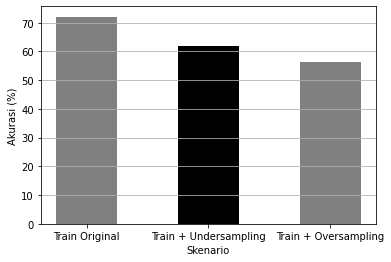

In [14]:
#evaluasi menampilkan nilai akurasi terbaik dari beberapa algoritma klasifikasi
bar = [1, 2, 3]
accuracy = []

data_train1 = pd.read_csv('csv/data_train1617.csv')
data_train2 = pd.read_csv('csv/data_train_undersample.csv')
data_train3 = pd.read_csv('csv/data_train_oversample.csv')

mk1 = data_train1
mk1 = mk1.drop(["KK"], axis=1)
mk1 = mk1.to_numpy()
mk2 = data_train2
mk2 = mk2.drop(["KK"], axis=1)
mk2 = mk2.to_numpy()
mk3 = data_train3
mk3 = mk3.drop(["KK"], axis=1)
mk3 = mk3.to_numpy()

kk1 = data_train1["KK"]
kk1 = kk1.astype(int)
kk1 = kk1.to_numpy()
kk2 = data_train2["KK"]
kk2 = kk2.astype(int)
kk2 = kk2.to_numpy()
kk3 = data_train3["KK"]
kk3 = kk3.astype(int)
kk3 = kk3.to_numpy()

X1 = mk1
y1 = kk1
X2 = mk2
y2 = kk2
X3 = mk3
y3 = kk3

xTrain1, xTest1, yTrain1, yTest1 = train_test_split(X1,y1, test_size = ukuran_test1, random_state = 42)
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(X2,y2, test_size = ukuran_test2, random_state = 42)
xTrain3, xTest3, yTrain3, yTest3 = train_test_split(X3,y3, test_size = ukuran_test3, random_state = 42)

#algoritma FKNN
FuzzyKNN_Model1 = FuzzyKNN(nilai_k_terbaik1)
FuzzyKNN_Model1.fit(xTrain1, yTrain1)
hasil = 100 * FuzzyKNN_Model1.score(xTest1, yTest1, 4)
accuracy.append(hasil)

#algoritma FKNN
FuzzyKNN_Model2 = FuzzyKNN(nilai_k_terbaik2)
FuzzyKNN_Model2.fit(xTrain2, yTrain2)
hasil = 100 * FuzzyKNN_Model2.score(xTest2, yTest2, 4)
accuracy.append(hasil)

#algoritma FKNN
FuzzyKNN_Model3 = FuzzyKNN(nilai_k_terbaik3)
FuzzyKNN_Model3.fit(xTrain3, yTrain3)
hasil = 100 * FuzzyKNN_Model3.score(xTest3, yTest3, 4)
accuracy.append(hasil)
 
tick_label = ['Train Original', 'Train + Undersampling', 'Train + Oversampling']
 
plt.bar(bar, accuracy, tick_label = tick_label,
        width = 0.5, color = ['grey', 'black', 'grey'])
 
plt.xlabel('Skenario')
plt.ylabel('Akurasi (%)')
plt.grid(axis = 'y')

# function to show the plot
plt.show()

In [15]:
accuracy

[72.08121827411168, 62.0, 56.29680054458815]

# Akurasi, precision, recall, f1score pada setiap skenario

In [16]:
#evaluasi hasil (akurasi, precision, recall, f1score) dari beberapa algoritma sebagai pembanding
#algoritma FKNN
prediction = []
Pred = FuzzyKNN_Model1.predict(xTest1, 4)
for index in Pred:
    prediction.append(index[0])
print("Fuzzy KNN Skenario 1")
print(classification_report(yTest1, prediction))

#algoritma FKNN
prediction = []
Pred = FuzzyKNN_Model2.predict(xTest2, 4)
for index in Pred:
    prediction.append(index[0])
print("Fuzzy KNN Skenario 2")
print(classification_report(yTest2, prediction))

#algoritma FKNN
prediction = []
Pred = FuzzyKNN_Model3.predict(xTest3, 4)
for index in Pred:
    prediction.append(index[0])
print("Fuzzy KNN Skenario 3")
print(classification_report(yTest3, prediction))

Fuzzy KNN Skenario 1
              precision    recall  f1-score   support

           0       0.68      0.44      0.54        34
           1       0.75      0.88      0.81        97
           2       1.00      0.31      0.47        26
           3       0.64      0.85      0.73        40

    accuracy                           0.72       197
   macro avg       0.77      0.62      0.64       197
weighted avg       0.75      0.72      0.70       197

Fuzzy KNN Skenario 2
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        24
           1       0.59      0.55      0.57        31
           2       0.77      0.57      0.65        30
           3       0.44      0.80      0.57        15

    accuracy                           0.62       100
   macro avg       0.63      0.65      0.62       100
weighted avg       0.65      0.62      0.62       100

Fuzzy KNN Skenario 3
              precision    recall  f1-score   support

           0

In [17]:
NaiveBayes_Model = GaussianNB()
NaiveBayes_Model.fit(xTrain1, yTrain1)

DecisionTree_Model = tree.DecisionTreeClassifier()
DecisionTree_Model.fit(xTrain1, yTrain1)

#algoritma Naive Bayes
Pred = NaiveBayes_Model.predict(xTest1)
print('Skenario 1')
print("Naive Bayes")
print(classification_report(yTest1, Pred))

#algoritma Decision Tree
Pred = DecisionTree_Model.predict(xTest1)
print("Decision Tree")
print(classification_report(yTest1, Pred))

Skenario 1
Naive Bayes
              precision    recall  f1-score   support

           0       0.60      0.53      0.56        34
           1       0.89      0.66      0.76        97
           2       0.59      0.62      0.60        26
           3       0.53      0.90      0.67        40

    accuracy                           0.68       197
   macro avg       0.65      0.68      0.65       197
weighted avg       0.73      0.68      0.69       197

Decision Tree
              precision    recall  f1-score   support

           0       0.51      0.53      0.52        34
           1       0.72      0.66      0.69        97
           2       0.29      0.35      0.32        26
           3       0.64      0.68      0.66        40

    accuracy                           0.60       197
   macro avg       0.54      0.55      0.55       197
weighted avg       0.61      0.60      0.60       197



In [18]:
NaiveBayes_Model = GaussianNB()
NaiveBayes_Model.fit(xTrain2, yTrain2)

DecisionTree_Model = tree.DecisionTreeClassifier()
DecisionTree_Model.fit(xTrain2, yTrain2)

#algoritma Naive Bayes
Pred = NaiveBayes_Model.predict(xTest2)
print('Skenario 2')
print("Naive Bayes")
print(classification_report(yTest2, Pred))

#algoritma Decision Tree
Pred = DecisionTree_Model.predict(xTest2)
print("Decision Tree")
print(classification_report(yTest2, Pred))

Skenario 2
Naive Bayes
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        24
           1       0.68      0.42      0.52        31
           2       0.52      0.53      0.52        30
           3       0.38      0.67      0.49        15

    accuracy                           0.50       100
   macro avg       0.51      0.52      0.50       100
weighted avg       0.53      0.50      0.50       100

Decision Tree
              precision    recall  f1-score   support

           0       0.48      0.58      0.53        24
           1       0.45      0.42      0.43        31
           2       0.68      0.50      0.58        30
           3       0.35      0.47      0.40        15

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.48       100
weighted avg       0.51      0.49      0.49       100



In [19]:
NaiveBayes_Model = GaussianNB()
NaiveBayes_Model.fit(xTrain3, yTrain3)

DecisionTree_Model = tree.DecisionTreeClassifier()
DecisionTree_Model.fit(xTrain3, yTrain3)

#algoritma Naive Bayes
Pred = NaiveBayes_Model.predict(xTest3)
print('Skenario 3')
print("Naive Bayes")
print(classification_report(yTest3, Pred))

#algoritma Decision Tree
Pred = DecisionTree_Model.predict(xTest3)
print("Decision Tree")
print(classification_report(yTest3, Pred))

Skenario 3
Naive Bayes
              precision    recall  f1-score   support

           0       0.58      0.41      0.48       370
           1       0.64      0.53      0.58       351
           2       0.64      0.63      0.64       370
           3       0.53      0.78      0.63       378

    accuracy                           0.59      1469
   macro avg       0.60      0.59      0.58      1469
weighted avg       0.60      0.59      0.58      1469

Decision Tree
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       370
           1       0.62      0.63      0.62       351
           2       0.73      0.81      0.77       370
           3       0.78      0.77      0.77       378

    accuracy                           0.73      1469
   macro avg       0.73      0.73      0.73      1469
weighted avg       0.73      0.73      0.73      1469



# Akurasi menggunakan cross validation pada tiap Skenario

In [20]:
#class algoritma klasifikasi Fuzzy K-Nearest Neighbor
class FuzzyKNN(BaseEstimator, ClassifierMixin):
    #function inisialisasi
    def __init__(self, k, plot=False): #banyaknya k
        self.k = k
        self.plot = plot
        
    #mengecek parameter yang dimasukkan apakah sudah sesuai sebelum menggunakan algoritma FKNN
    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
            
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')
        
    #melatih/membuat model berdasarkan data train yang dimasukkan
    def fit(self, X, y=None):
        self._check_params(X,y) #memanggil fungsi check_parameter
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        
        classes = list(set(y))
        classes.sort()
        self.classes = classes
        
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        
        self.memberships = self._compute_memberships() #memanggil fungsi compute membership
        
        self.df['membership'] = self.memberships
        
        self.fitted_ = True
        return self
    
    #memprediksi data baru (testing) masuk ke dalam class mana
    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            m = 4 #menentukan faktor skala dalam pembobotan
            y_pred = []
            
            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
                
                votes = {}
                for c in self.classes:
                    den = 0
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        den += 1 / (dist ** (2 / (m-1)))
                    
                    neighbors_votes = []
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        num = (neighbors.iloc[n].membership[c]) / (dist ** (2 / (m-1)))
                        
                        vote = num/den
                        neighbors_votes.append(vote)
                    votes[c] = np.sum(neighbors_votes)
                    
                pred = max(votes.items(), key=operator.itemgetter(1))[0]
                y_pred.append((pred, votes))
                
            return y_pred
        
    #menampilkan nilai akurasi dari model yang sudah dibuat
    def score(self, X, y):
        if self.fitted_ == None:
            raise Exception('score() called before fit()')
        else:
            predictions = self.predict(X)
            y_pred = [t[0] for t in predictions]
            confidences = [t[1] for t in predictions]
            
            return accuracy_score(y_pred=y_pred, y_true=y)
    
    #mencari tetangga terdekat berdasarkan K
    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values
        
        df['distances'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]
        
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

    #menentukan hasil tetangga terdekat dari proses function find KNN        
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        
        return counts
        
    #menghitung inisialisasi fuzzy untuk menghitung nilai keanggotaannya
    def _compute_memberships(self):
        memberships = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y[i]
            
            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x) #memanggil fungsi find_knn
            counts = self._get_counts(neighbors)
        
            membership = dict()
            for c in self.classes:
                try:
                    #rumus inisialisasi fuzzy
                    uci = 0.49 * (counts[c] / self.k)
                    if c == y:
                        uci += 0.51
                    membership[c] = uci
                except:
                    membership[c] = 0
                    
            memberships.append(membership)
        return memberships

In [21]:
#cross_validation_score
#function menghitung nilai rata-rata pada cross validation score
def rata_rata(arra,cv):
    total = 0
    
    for i in arra:
        total = total + i
    total = (total / cv) * 100
    
    return(total)

#evaluasi menghitung nilai akurasi yang didapat menggunakan metode cross validation score
FuzzyKNN_Model1 = FuzzyKNN(nilai_k_terbaik1)
FuzzyKNN_Model1.fit(xTrain1, yTrain1)
score = cross_val_score(cv=5, estimator=FuzzyKNN_Model1, X = xTest1, y = yTest1)
print("Fuzzy K Neighbour Scenario 1 = ", score)
print("Rata - rata                  = ", rata_rata(score,5))
print(" ")

#evaluasi menghitung nilai akurasi yang didapat menggunakan metode cross validation score
FuzzyKNN_Model2 = FuzzyKNN(nilai_k_terbaik2)
FuzzyKNN_Model2.fit(xTrain2, yTrain2)
score = cross_val_score(cv=5, estimator=FuzzyKNN_Model2, X = xTest2, y = yTest2)
print("Fuzzy K Neighbour Scenario 2 = ", score)
print("Rata - rata                  = ", rata_rata(score,5))
print(" ")

#evaluasi menghitung nilai akurasi yang didapat menggunakan metode cross validation score
FuzzyKNN_Model3 = FuzzyKNN(nilai_k_terbaik3)
FuzzyKNN_Model3.fit(xTrain3, yTrain3)
score = cross_val_score(cv=5, estimator=FuzzyKNN_Model3, X = xTest3, y = yTest3)
print("Fuzzy K Neighbour Scenario 3 = ", score)
print("Rata - rata                  = ", rata_rata(score,5))
print(" ")

Fuzzy K Neighbour Scenario 1 =  [0.725      0.6        0.53846154 0.53846154 0.71794872]
Rata - rata                  =  62.39743589743589
 
Fuzzy K Neighbour Scenario 2 =  [0.7  0.55 0.55 0.45 0.5 ]
Rata - rata                  =  55.00000000000001
 
Fuzzy K Neighbour Scenario 3 =  [0.39455782 0.44557823 0.45578231 0.39795918 0.41979522]
Rata - rata                  =  42.27345545726823
 


In [22]:
NaiveBayes_Model = GaussianNB()
NaiveBayes_Model.fit(xTrain1, yTrain1)

DecisionTree_Model = tree.DecisionTreeClassifier()
DecisionTree_Model.fit(xTrain1, yTrain1)

score = cross_val_score(cv=5, estimator=NaiveBayes_Model, X=xTest1, y=yTest1)
print("Scenario 1")
print("")
print("Naive Bayes = ", score)
print("Rata - rata = ", rata_rata(score,5))
print(" ")

score = cross_val_score(cv=5, estimator=DecisionTree_Model, X=xTest1, y=yTest1)
print("Decision Tree = ", score)
print("Rata - rata = ", rata_rata(score,5))

Scenario 1

Naive Bayes =  [0.725      0.55       0.56410256 0.61538462 0.64102564]
Rata - rata =  61.9102564102564
 
Decision Tree =  [0.6        0.475      0.64102564 0.58974359 0.61538462]
Rata - rata =  58.423076923076934


In [23]:
NaiveBayes_Model = GaussianNB()
NaiveBayes_Model.fit(xTrain2, yTrain2)

DecisionTree_Model = tree.DecisionTreeClassifier()
DecisionTree_Model.fit(xTrain2, yTrain2)

score = cross_val_score(cv=5, estimator=NaiveBayes_Model, X=xTest2, y=yTest2)
print("Scenario 1")
print("")
print("Naive Bayes = ", score)
print("Rata - rata = ", rata_rata(score,5))
print(" ")

score = cross_val_score(cv=5, estimator=DecisionTree_Model, X=xTest2, y=yTest2)
print("Decision Tree = ", score)
print("Rata - rata = ", rata_rata(score,5))

Scenario 1

Naive Bayes =  [0.55 0.55 0.7  0.4  0.45]
Rata - rata =  53.0
 
Decision Tree =  [0.55 0.3  0.5  0.25 0.45]
Rata - rata =  41.0


In [24]:
NaiveBayes_Model = GaussianNB()
NaiveBayes_Model.fit(xTrain3, yTrain3)

DecisionTree_Model = tree.DecisionTreeClassifier()
DecisionTree_Model.fit(xTrain3, yTrain3)


score = cross_val_score(cv=5, estimator=NaiveBayes_Model, X=xTest3, y=yTest3)
print("Scenario 1")
print("")
print("Naive Bayes = ", score)
print("Rata - rata = ", rata_rata(score,5))
print(" ")

score = cross_val_score(cv=5, estimator=DecisionTree_Model, X=xTest3, y=yTest3)
print("Decision Tree = ", score)
print("Rata - rata = ", rata_rata(score,5))

Scenario 1

Naive Bayes =  [0.65646259 0.65306122 0.67006803 0.64285714 0.6894198 ]
Rata - rata =  66.23737549627359
 
Decision Tree =  [0.84353741 0.82993197 0.88435374 0.86734694 0.87030717]
Rata - rata =  85.90954470525412
